<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/simulate_fourier_slice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* simulate particles from arbitrary density map (e.g. published map on EMDB)

#Setup

In [1]:
!pip install mrcfile
import mrcfile

     |████████████████████████████████| 51kB 3.1MB/s 


In [2]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
!rm fourier.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/db1d53f84d256916f8f79fae1100e1b2ac9b01fa/src/fourier.py
!rm transfer.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/db1d53f84d256916f8f79fae1100e1b2ac9b01fa/src/transfer.py
!rm simulate.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/db1d53f84d256916f8f79fae1100e1b2ac9b01fa/src/simulate.py
!pip install pyfftw
import coords, fourier, transfer, simulate
import importlib
importlib.reload(fourier)
importlib.reload(simulate)
importlib.reload(transfer)

--2021-04-12 16:45:10--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2603 (2.5K) [text/plain]
Saving to: ‘coords.py’

coords.py           100%[===================>]   2.54K  --.-KB/s    in 0s      

2021-04-12 16:45:10 (17.6 MB/s) - ‘coords.py’ saved [2603/2603]

rm: cannot remove 'fourier.py': No such file or directory
--2021-04-12 16:45:11--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/db1d53f84d256916f8f79fae1100e1b2ac9b01fa/src/fourier.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:4

<module 'transfer' from '/content/transfer.py'>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def doplt(arr2d,cmap='gray',**kwargs):
  plt.imshow(arr2d,cmap=cmap,**kwargs)
from scipy.ndimage import map_coordinates
import numba

# Download map from EMDB
* use map from hetergenous ribosome paper. 
  * resolution ranges 3.7 - ~ 6 A
  * C1 symmetry
  * https://www.empiar.org/EMPIAR-10076
  * https://www.ebi.ac.uk/pdbe/entry/emdb/EMD-8450 3.7 A
  * https://www.ebi.ac.uk/pdbe/entry/emdb/EMD-8441 3.7 A

In [3]:
!wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-8450/map/emd_8450.map.gz

--2021-04-12 16:45:21--  ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-8450/map/emd_8450.map.gz
           => ‘emd_8450.map.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.197.74
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.197.74|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/emdb/structures/EMD-8450/map ... done.
==> SIZE emd_8450.map.gz ... 104651210
==> PASV ... done.    ==> RETR emd_8450.map.gz ... done.
Length: 104651210 (100M) (unauthoritative)

emd_8450.map.gz     100%[===================>]  99.80M  30.6MB/s    in 3.6s    

2021-04-12 16:45:25 (27.6 MB/s) - ‘emd_8450.map.gz’ saved [104651210]



In [4]:
!gunzip emd_8450.map.gz

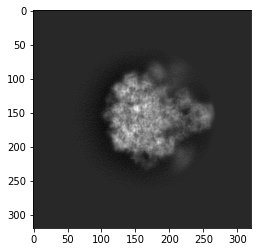

In [7]:
fname = 'emd_8450.map'
map_mrc = mrcfile.open(fname)
map_original = map_mrc.data
N = map_original.shape[0]
psize_original = map_mrc.voxel_size.item(0)[0]
psize = psize_original
doplt(map_original.sum(0))

# 3D Map
Now we simualte slices from an arbitrary map
* Zero pad the input volume
* 3D FFT the map
* Rotate (x,y,0) plane by desired rotation to get non-cartesian grid points
* Interpolate Fourier-transformed map at these points: this gives a 2D slice in Fourier space
* add CTF and noise if desired
* take 2D iFFT

## 3D FFT

In [8]:
map_f = fourier.do_fft(map_original)

## Rotate

In [10]:
N = map_f.shape[0]
xyz = coords.coords_n_by_d(np.arange(-N//2,N//2),d=3)
idx_z0 = xyz[:,-1] == 0 
xy0 = xyz[idx_z0]

In [11]:
n_particles=3
np.random.seed(0)
qs = coords.get_random_quat(n_particles)
Rs = coords.quaternion_to_R(qs.T)
Rs.shape

(3, 3, 3)

## CTFs

* If there are CTF aliasig issues, we can zero pad the initial volume (up sample)

Perhaps it’s more realistic to simulate things with a very uniform set of defoci (from ~0.75 - 3.5 um, for instance). In an experiment, even if you keep the scope set at the same defocus, there are variations in the sample height as you move around the grid (same as defocus), and this ends up changing the defocus. Some people change it up from area to area during screening. One questions experimentalists sometimes want to know is “what is a good range of defocus”? If the defocus is small, like 1 um, it’s harder to see the particles and pick them, but it doesn’t delocalize the information as much. Of course, in the end you need a bit of a range to fill out the zeros in the CTF…

With good alignment, the astigmatism should be low (elipticity of the pattern from difference between df1 and df2; df1=df2 implies zero astigmatism).

In [12]:
%%time
np.random.seed(0)
df_min, df_max = 15000, 20000
dfs = np.random.uniform(low=df_min,high=df_max,size=n_particles)
df_diff_min, df_diff_max = 100, 500
df_diff = np.random.uniform(low=df_diff_min,high=df_diff_max,size=n_particles)
df1s = dfs - df_diff/2
df2s = dfs + df_diff/2
df_ang_min, df_ang_max = 0, 360
df_ang_deg = np.random.uniform(low=df_ang_min,high=df_ang_max,size=n_particles)
CTFs = np.empty((n_particles,N,N))
kv=300
cs = 2.0
ac=0.1
freq_A_2d, angles_rad = transfer.ctf_freqs(N,psize,d=2)
for idx in range(n_particles):
  if idx % max(1,(n_particles//10)) == 0: print(idx)
  CTFs[idx] = transfer.eval_ctf(freq_A_2d, angles_rad, def1=df1s[idx], def2=df2s[idx], angast=df_ang_deg[idx], phase=0, kv=kv, ac=ac, cs=cs, bf=0)

0
1
2
CPU times: user 1.66 s, sys: 13.8 ms, total: 1.67 s
Wall time: 1.66 s


Text(0.5, 1.0, 'N=320 | df1 = 1.78 um| df2 = 1.82 um')

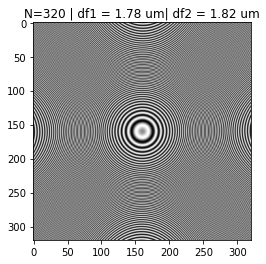

In [13]:
doplt(CTFs[idx])
plt.title('N=%i | df1 = %.2f um| df2 = %.2f um'%(N,df1s[idx]/10000,df2s[idx]/10000))

## Take slice (interpolate) and 2D-iFFT

In [14]:
%%time
proj_f = np.zeros((n_particles,N,N),dtype=np.complex64)
snr = 1
for idx in range(n_particles):
  if idx % max(1,(n_particles//10)) == 0: print(idx)
  R = Rs[:,:,idx]
  xy0_rot = R.dot(xy0.T).T
  proj_f[idx] = (map_coordinates(map_f.real, xy0_rot.T + N//2,order=1).astype(np.complex64) + 1j*map_coordinates(map_f.imag, xy0_rot.T + N//2,order=1).astype(np.complex64)).reshape(N,N) # important to keep order=1 for speed. linear is good enough
  proj_f[idx] *= CTFs[idx] # can compute CTF on the fly if memory issues


0
1
2
CPU times: user 230 ms, sys: 495 ms, total: 725 ms
Wall time: 186 ms


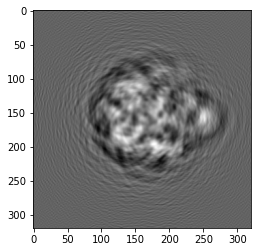

In [15]:
doplt(fourier.do_ifft(proj_f[0],d=2))

## Fourier crop
* If desired we can Fourier crop to a different pixel size, for instance 128 vs 320 for EMDB-8450. We loose resolution, but win on speedups
* We do the Fourier crop now, after the CTF, so that we have less aliasing issues from the rapid oscilations in the CTF at small box size and high defoci.

In [16]:
%%time
N_crop = 128
i,f = N//2-N_crop//2, N//2+N_crop//2
proj_r = np.zeros((n_particles,N_crop,N_crop))
for idx in range(n_particles):
  proj_r[idx] = fourier.do_ifft(proj_f[idx,i:f,i:f],d=2)
psize_crop = psize_original*N/N_crop
psize_crop

CPU times: user 3.18 ms, sys: 182 µs, total: 3.37 ms
Wall time: 2.8 ms


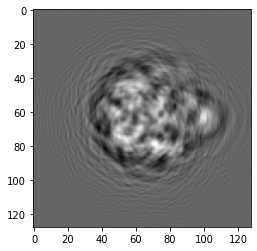

In [17]:
doplt(proj_r[0])

## Noise
* do after the croping, so the SNR corresponds to the final output particles
* while some authors define SNR as log $\sigma^2_{signal}/\sigma^2_{noise}$ ; or $\sigma^2_{signal}/\sigma^2_{noise}$ (cf. Penczek 2010), we define it here as $\sigma_{signal}/\sigma_{noise}$ following cryoSPARC's simulate data job
* one could also save particles and add in different levels of noise later, and compare things.
  * Penczek, P. A. (2010). Image restoration in cryo-electron microscopy. Methods in Enzymology (1st ed., Vol. 482). Elsevier Inc. http://doi.org/10.1016/S0076-6879(10)82002-6

In [38]:
%%time
snr = 0.5
signal = np.std(proj_r)
noise = signal/snr
np.random.seed(0)
proj_r_noise = np.random.normal(loc=proj_r,scale=noise)

CPU times: user 4.41 ms, sys: 2.13 ms, total: 6.54 ms
Wall time: 5.5 ms


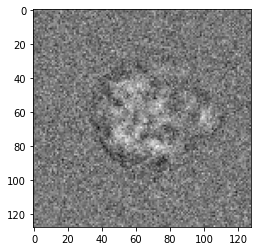

In [39]:
doplt(proj_r_noise[0])

# Write to mrc file

In [112]:
ofname = 'particles.mrc'
with mrcfile.new(ofname, overwrite=True) as mrc:
  mrc.set_data(proj_r_noise.astype(np.float32)) # see notes on float64 not supported https://mrcfile.readthedocs.io/en/latest/usage_guide.html

# Read from mrc file

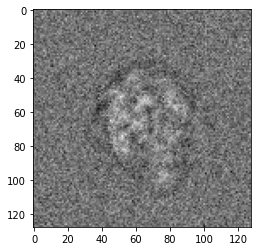

In [191]:
particles_mrc = mrcfile.open(ofname)
particles = particles_mrc.data
doplt(particles[1])

# Output metadata

In [220]:
df = pd.DataFrame({'df1_A':df1s,'df2_A':df2s,'df_ang_deg':df_ang_deg,'kev':kv,'ac':ac,'cs_mm':cs,
              'rotation_quaternion':[q for q in qs]
            })
df.to_csv('metadata.tsv',sep='\t')

In [221]:
!head metadata.tsv

	df1_A	df2_A	df_ang_deg	kev	ac	cs_mm	rotation_quaternion
0	17585.090883037246	17903.044156236003	157.5313960545693	300	0.1	2.0	[0.50724516 0.44032811 0.47004935 0.57259682]
1	18441.215871994315	18710.67779172988	321.03828028154874	300	0.1	2.0	[0.32950959 0.41980241 0.83349753 0.14307774]
2	17834.638057744887	18192.99570297155	346.91859378037054	300	0.1	2.0	[0.53525597 0.33277269 0.77511402 0.04429038]


# `simulate.py`

In [19]:
proj_r,proj_r_noise,meta_data_df = simulate.simulate(map_original,psize_original,n_particles=10,snr=1,N_crop=128,do_log=False)

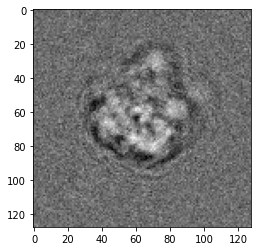

In [23]:
doplt(proj_r_noise[0])